### Question 1: Swarm behavior

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def f(x):
    res = 0
    for xi in x:
        res += -1*xi*np.sin(np.sqrt(abs(xi)))
    return res

def g(x):
    return np.array([xi**2 for xi in x])

def fitness(x, fn, minimum):
    return fn(x) - minimum
#837.9658
def next_velocity(x, omega):
    return omega*x["v"]+0.5*(x["loc"]-x["cur"])+0.5*(x["soc"]-x["cur"])

def next_position(x):
    return x["cur"] + x["v"]

def update(swarm, itr, fn, omega, minimum):
    fit = -1000
    update_global = False
    for i in range(itr):
        for x in swarm:
            x["v"] = next_velocity(x, omega)
            x["cur"] = next_position(x)
            
            if fitness(x["cur"], fn, minimum) > fitness(x["loc"], fn, minimum):
                x["loc"] = x["cur"]
            
            if fitness(x["cur"], fn, minimum) > fitness(x["soc"], fn, minimum):
                update_global = True
                global_best = x["cur"]
                
        if update_global:
            for x in swarm:
                x["soc"] = global_best
        x_pos = np.array([swarm[i]["cur"] for i in range(len(swarm))])
    return x_pos


[[-432.5 -432.5]
 [-437.5 -437.5]
 [-440.  -440. ]] [[-488.75 -488.75]
 [-467.5  -467.5 ]
 [-465.   -465.  ]] [[-429.375 -429.375]
 [-415.5   -415.5  ]
 [-417.5   -417.5  ]]


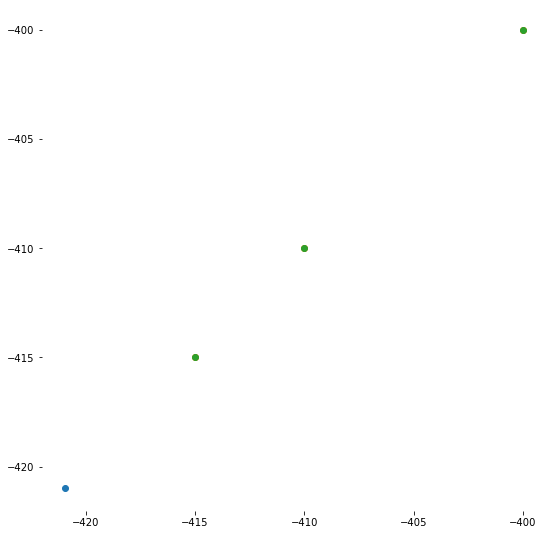

In [3]:
x1 = {"cur":np.array([-400, -400]), "loc":np.array([-400, -400]), "soc":np.array([-415, -415]), "v":np.array([-50, -50])}
x2 = {"cur":np.array([-410, -410]), "loc":np.array([-410, -410]), "soc":np.array([-415, -415]), "v":np.array([-50, -50])}
x3 = {"cur":np.array([-415, -415]), "loc":np.array([-415, -415]), "soc":np.array([-415, -415]), "v":np.array([-50, -50])}

x_pos = np.array([x1["cur"], x2["cur"], x3["cur"]])
swarm = np.array([x1, x2, x3])

x_pos1 = update(swarm, 1, f, 0.5, 837.9658)
x_pos2 = update(swarm, 1, f, 2, 837.9658)
x_pos3 = update(swarm, 1, f, 0.1, 837.9658)

print(x_pos1, x_pos2, x_pos3)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.scatter(-420.9687, -420.9687)
ax.scatter(x_pos[:,0], x_pos[:,1])
plt.scatter(x_pos[:,0], x_pos[:,1])
plt.show()

### Question 2: Single particle

In [4]:
single = {"cur":np.array([20]), "loc":np.array([20]), "soc":np.array([20]), "v": np.array([10])}
update([single], 100, g, 0.9, 0)

array([[109.99760947]])

### Question 3: Clustering

In [5]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

--2021-02-15 09:50:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [application/x-httpd-php]
Saving to: ‘iris.data.1’

iris.data.1         100%[===================>]   4.44K  --.-KB/s    in 0s      

2021-02-15 09:50:02 (22.7 MB/s) - ‘iris.data.1’ saved [4551/4551]



In [6]:
import pandas as pd
import random
from tqdm import tqdm
data = pd.read_csv("iris.data", header=None)
data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [7]:
def random_centroid(data):
    m0 = random.uniform(min(data[0]), max(data[0]))
    m1 = random.uniform(min(data[1]), max(data[1]))
    m2 = random.uniform(min(data[2]), max(data[2]))
    m3 = random.uniform(min(data[3]), max(data[3]))
    centroid = np.array([m0, m1, m2, m3])
    return centroid

In [8]:
# Represent cluster
ncentroids = 5
ncols = 4
nrows = len(data)
nparticles = 100

centroids = []
particles = []

def dst(x, c):
    return np.linalg.norm(x-c)


def quantization_error(p):
    total_clusters = 0
    total_single = 0
    for c in p["clusters"]:
        for dp in c["dps"]:
            total_single += dst(dp, c["centroid"])/len(c["dps"])
        total_clusters += total_single
    return total_clusters/len(p["clusters"])

v = 1
for p in range(nparticles):
    particle = {}
    for i in range(ncentroids):
        centroid = random_centroid(data)
        x = {"centroid":centroid, 
             "dps":np.zeros((1, 4)),
             "v":v,
             "loc":centroid}
        centroids.append(x)
    centroids = np.array(centroids)
    particle["clusters"] = centroids                  
    particle["fitness"] = quantization_error(particle)
    particles.append(particle)
    centroids = []
# Swarm of candidate clusterings
global_best = 100000
itr = 100

#For i in iterations
for i in tqdm(range(itr)):
    for p in particles:
        for dp in data.to_numpy():
            best = 10000                  # A very big number
            cluster = None
            for centroid in p["clusters"]:            # Calculate Euclidean distance to all centroids
                distance = dst(dp[:-1], centroid["centroid"])  
                if distance < best:
                    best = distance
                    cluster = centroid
            cluster["dps"] = np.vstack((cluster["dps"], dp[:-1]))     # Assign datavector to closest centroid
        
        p["fitness"] = quantization_error(p)             # Quantization error fitness of particle
    
        if p["fitness"] < global_best:
            global_best = p["fitness"]
    
    for p in particles:
        for c in p["clusters"]:     # For each particle update centroid 
            vnew = 0.73*c["v"]+1.5*(c["loc"]-c["centroid"])+1.5*(global_best-x["centroid"])
            c["v"] = vnew
            c["centroid"] = c["centroid"] + vnew
            
        if p["fitness"] > quantization_error(p):
            for c in p["clusters"]:
                c["loc"] = c["centroid"]
    
    for p in particles:
        if i < itr-2:
            for c in p["clusters"]:
                c["dps"] = np.zeros((1, 4))

        


100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


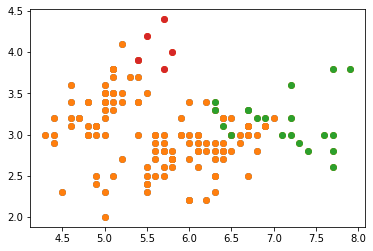

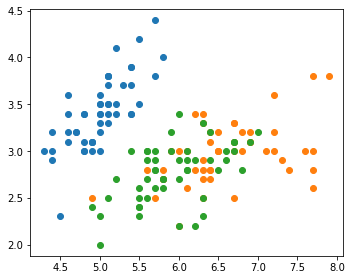

In [9]:
best = 100000
for p in particles:
    if p["fitness"] < best:
        best_p = p
        

for c in best_p["clusters"]:
    plt.scatter(c["dps"][1:,0], c["dps"][1:,1])
# The indices of the features that we are plotting
x_index = 0
y_index = 1


plt.figure(figsize=(5, 4))
setosa = data[data[4] == "Iris-setosa"].to_numpy()
virginica =  data[data[4] == "Iris-virginica"].to_numpy()
versicolor =  data[data[4] == "Iris-versicolor"].to_numpy()

for iris in (setosa, virginica, versicolor):
    plt.scatter(iris[:, x_index], iris[:, y_index])

plt.tight_layout()
plt.show()

In [14]:
def random_centroid(data):
    m0 = random.uniform(min(data[0]), max(data[0]))
    m1 = random.uniform(min(data[1]), max(data[1]))
    m2 = random.uniform(min(data[2]), max(data[2]))
    m3 = random.uniform(min(data[3]), max(data[3]))
    centroid = np.array([m0, m1, m2, m3])
    return centroid

def dst(x, c):
    return np.linalg.norm(x - c)

nclusters = 5
iterations = 1000
clusters = []
for i in range(nclusters):
    cluster = {}
    cluster["centroid"] = random_centroid(data)
    cluster["data"] = np.zeros((1,4))
    clusters.append(cluster)

for i in tqdm(range(iterations)):
    for vector in data.to_numpy():
        best = 10000
        centroid = None
        for cluster in clusters:
            new_dst = dst(vector[:-1], cluster["centroid"])
            if new_dst < best:
                best = new_dst
                best_centroid = cluster
        best_centroid["data"] = np.vstack((best_centroid["data"], vector[:-1]))
    
    for cluster in clusters:
        cluster["centroid"] = cluster["data"].mean(axis=0)
        if i < iterations-1:
            cluster["data"] = np.zeros((1,4))



100%|██████████| 1000/1000 [00:08<00:00, 122.91it/s]


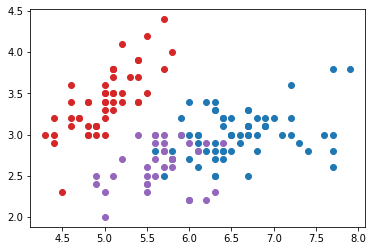

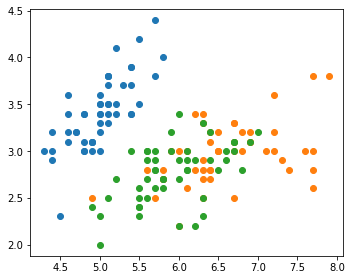

In [15]:
for c in clusters:
    plt.scatter(c["data"][1:,0], c["data"][1:,1])
plt.show()

plt.figure(figsize=(5, 4))
setosa = data[data[4] == "Iris-setosa"].to_numpy()
virginica =  data[data[4] == "Iris-virginica"].to_numpy()
versicolor =  data[data[4] == "Iris-versicolor"].to_numpy()

for iris in (setosa, virginica, versicolor):
    plt.scatter(iris[:, x_index], iris[:, y_index])

plt.tight_layout()
plt.show()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1], dtype=int32)